# Capstone Project Technical Notebook - Knitting Pattern Recommender

## 1. Business Understanding

Ravelry.com is a database-driven website where users can browse and download knitting and crochet patterns, track their progress on a given project, and review the patterns. 

It currently has a "your pattern highlights" recommender system. Compared to the front-and-centre recommendations that Netflix or Amazon make to their users, it's tucked away at the bottom of the patterns search page, displaying only thumbnail images of the recommended pattterns. 

The recommendations generated appear to be based on clicks and/or favourites, rather than a more comprehensive examination of what projects users actually work on and rate positively, having experienced making them. 

The aim of this project is to provide more tailored recommendations for knitting patterns to users of Ravelry.com, based on patterns they have worked on and rated already. 

## 2. Data Understanding

The data has all been obtained through the Ravelry.com API. Since the website does not have an app, it makes all of its content available through APIs, and at present there are 41 apps which make use of some or all of the websites functionality.

The modelling features for a collaborative filtering recommender system are users, items and ratings. the model finds similarities between users based on their ratings of items, and uses these similarities to predict ratings for items for users who have not already rated them. 


In [79]:
# import libraries

import surprise
from surprise.prediction_algorithms import *
import pandas as pd
import numpy as np
import datetime as dt
import requests
import json
import math

In [80]:
# block pandas warnings

import warnings
warnings.filterwarnings('ignore')

In [81]:
# open credentials

with open('.secrets/creds.json') as f:
    creds = json.load(f)

In [82]:
# import data and drop null ratings

input_df = pd.read_csv('Data/saved_100000_calls.csv')


### EDA:

In [83]:
print('Initially:', 100000, 'users sampled.')
print(len(pd.unique(input_df['user'])), 'of those had tracked', len(input_df), 'projects based on knitting patterns.')

input_df_non_NA = input_df.dropna(subset = ['rating'])

print(len(pd.unique(input_df_non_NA['user'])), 
      'unique users have given',
      len(input_df_non_NA),
      'non-NA ratings to',
      len(pd.unique(input_df_non_NA['pattern_id'])),
      'unique knitting patterns (items).')

Initially: 100000 users sampled.
8531 of those had tracked 156206 projects based on knitting patterns.
4140 unique users have given 104710 non-NA ratings to 44459 unique knitting patterns (items).


The histogram of ratings shows that users are far  more likely to favourably rate a pattern they have already chosen to work on, with 99183 of the 104710 ratings a 3, or higher. (maximum rating = 4)


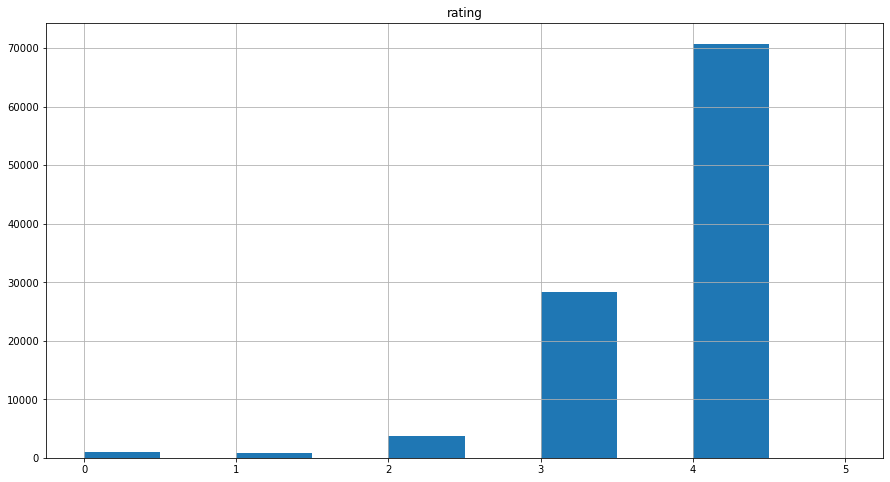

In [84]:
input_df.dropna(subset = ['rating']).hist('rating', figsize = (15,8))

print('The histogram of ratings shows that users are far', 
      ' more likely to favourably rate a pattern they have already chosen to work on, with', 
      len(input_df_non_NA[input_df_non_NA['rating']>=3]),
      'of the',
      len(input_df_non_NA),
      'ratings a 3, or higher. (maximum rating = 4)')



3893 of the 4140 rating users ( 94.03 %), tracked and rated 100 projects or fewer.
60.7 % of all rating users tracked and rated 10 projects or fewer.


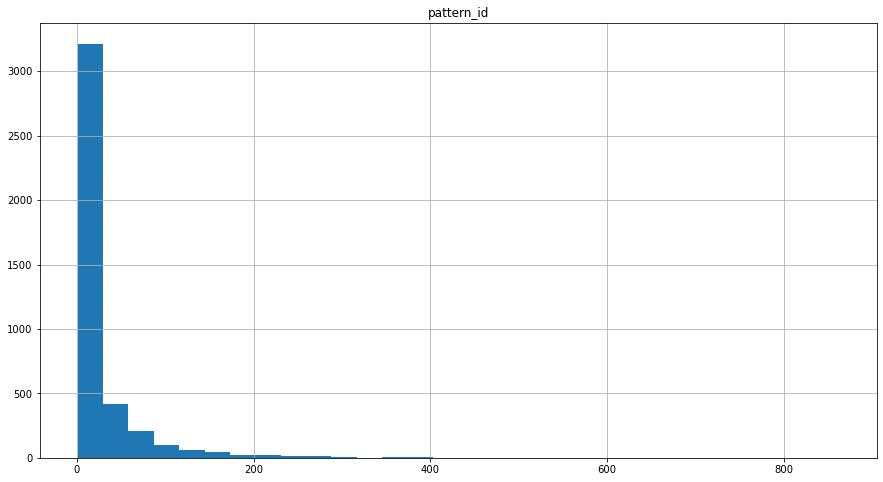

In [85]:
input_df_non_NA.groupby('user').count().hist('pattern_id',figsize = (15,8), bins = 30)

x = len(input_df_non_NA.groupby('user').count()[input_df_non_NA.groupby('user').count()['pattern_id'] <= 100])
y = len(pd.unique(input_df_non_NA['user']))

print(x, 'of the', y, 'rating users (', round(100*x/y,2),'%), tracked and rated 100 projects or fewer.')
z = len(input_df_non_NA.groupby('user').count()[input_df_non_NA.groupby('user').count()['pattern_id'] <= 10])

print(round(100*z/y,2), '% of all rating users tracked and rated 10 projects or fewer.')

Note: Should I randomly sample input_df for each run? To get more variation in recommendations and speed up run time?

## 3. Data Preparation

The model was tested on the data with missing ratings removed, and then with missing ratings replaced with pattern averages. Replacing missing values with pattern averages negatively impacted the RMSE for SVD, so proceeded with the missing values dropped. 

Also, one series of the dataframe contained lists which converted to strings after reading from the CSV. These were converted back to lists by slicing and splitting. 

Lastly, the sk surprise package requires a specific version of the data to run its models, generated by passing the dataframe containing only user, item and rating (in that order) to the <code>load_from_df</code> and then <code>train_test_split</code> (for evaluation) or <code>build_full_trainset</code> (for final model) methods.  

In [86]:
df_drop_nans = input_df[['user', 'pattern_id', 'rating']].dropna(subset = ['rating'])

In [87]:
# replace Nan ratings with pattern average. note - this negatively impacts RMSE, so the dataframe with dropped Nans is used
# for modelling

df_replace_nans = input_df[['user', 'pattern_id', 'rating', 'average_rating']]
rating_replace_nans = df_replace_nans['rating'].fillna(df_replace_nans['average_rating'])
df_replace_nans['rating'] = rating_replace_nans
df_replace_nans.drop(columns = 'average_rating', inplace = True)

In [88]:
# a list of users in the original data

users_list = list(df_drop_nans['user'].unique())

In [89]:
# a dataframe with a list of applicable categories (usually only one) for each pattern

# to-do: vectorize this for loop. 

df_pattern_ids_and_categories = input_df[['pattern_id', 'categories']]
df_pattern_ids_and_categories = df_pattern_ids_and_categories.drop_duplicates(subset=['pattern_id'])
df_pattern_ids_and_categories['cat_list'] = ''
for pattern in list(df_pattern_ids_and_categories.index):
    df_pattern_ids_and_categories['cat_list'][pattern] = [category[1:-1] for category in df_pattern_ids_and_categories['categories'][pattern][1:-1].split(', ')]


In [90]:
# transform data for surprise

from surprise import Reader, Dataset

reader = Reader()

data_drop = Dataset.load_from_df(df_drop_nans, reader)
data_replace = Dataset.load_from_df(df_replace_nans, reader)

# train test split for model evaluation

from surprise.model_selection import train_test_split

drop_trainset, drop_testset = train_test_split(data_drop, test_size=0.25)
replace_trainset, replace_testset = train_test_split(data_replace, test_size=0.25)

## 4. Modelling

Many of the KNN, Matrix Factorization, Slope One, and Co-Clustering modelling methods within the sk surprise package were used, and evaluated based on their RMSE on predicted ratings, using a 25% train test split. 

#### SVD - dropped NAs

In [91]:
from surprise import SVD, accuracy

SVD_1_drop = SVD(n_factors = 40, n_epochs = 45, lr_all = 0.002, reg_all = 0.2)
SVD_1_drop.fit(drop_trainset)

accuracy.rmse(SVD_1_drop.test(drop_testset))

RMSE: 0.6416


0.6415636300345143

#### SVD - replaced NAs

In [92]:
SVD_1_replace = SVD(n_factors = 40, n_epochs = 45, lr_all = 0.002, reg_all = 0.2)
SVD_1_replace.fit(replace_trainset)

accuracy.rmse(SVD_1_replace.test(replace_testset))

RMSE: 0.8893


0.8892679228246649

#### GridSearch on SVD - dropped NAs

In [ ]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors':[5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
              'n_epochs': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50], 
              'lr_all': [0.002, 0.003, 0.004, 0.005],
              'reg_all': [0.2, 0.3, 0.4, 0.5, 0.6]}

gs_model = GridSearchCV(SVD,
                        param_grid=param_grid,
                        n_jobs = -1,
                        joblib_verbose=5)

gs_model.fit(data_drop)

gs_model.best_params

In [93]:
# from GridSearch

GS_SVD = SVD(n_factors = 5, n_epochs = 40, lr_all = 0.002, reg_all = 0.2)
GS_SVD.fit(drop_trainset)

predictions = GS_SVD.test(drop_testset)
accuracy.rmse(predictions)

RMSE: 0.6414


0.6414152971961721

#### Single Variable Decomposition - SVD++

In [94]:
SVDppmodel = SVDpp(n_factors = 15, n_epochs = 30, lr_all = 0.003, reg_all = 0.2)

SVDppmodel.fit(drop_trainset)
predictions = SVDppmodel.test(drop_testset)
accuracy.rmse(predictions)

RMSE: 0.6418


0.6417828699437014

#### GridSearch on SVD++ - dropped NAs

In [ ]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors':[5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
              'n_epochs': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50], 
              'lr_all': [0.002, 0.003, 0.004, 0.005],
              'reg_all': [0.2, 0.3, 0.4, 0.5, 0.6]}

gs_model = GridSearchCV(SVDpp,
                        param_grid=param_grid,
                        n_jobs = -1,
                        joblib_verbose=5)

gs_model.fit(data_drop)

gs_model.best_params

### Other Surprise Models

In [95]:
from surprise.prediction_algorithms import knns
from surprise.similarities import cosine, msd, pearson


To-do: Try these 7 on the data_replace?

#### KNN Basic - cosine similarity

In [96]:
sim_cos = {'name':'cosine', 'user_based':True}

basic = knns.KNNBasic(min_k = 8, sim_options=sim_cos)
basic.fit(drop_trainset)
predictions = basic.test(drop_testset)
print(accuracy.rmse(predictions))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6950
0.6949637934100508


#### KNN Basic - Pearson similarity

In [97]:
sim_pearson = {'name':'pearson', 'user_based':True}

basic = knns.KNNBasic(min_k = 8, sim_options=sim_pearson)
basic.fit(drop_trainset)
predictions = basic.test(drop_testset)
print(accuracy.rmse(predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.6944
0.6943652718693034


#### KNN with Means - Pearson similarity

In [98]:
sim_pearson = {'name':'pearson', 'user_based':True}

basic = knns.KNNWithMeans(min_k = 8, sim_options=sim_pearson)
basic.fit(drop_trainset)
predictions = basic.test(drop_testset)
print(accuracy.rmse(predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.6668
0.6667755458417308


#### KNN Baseline - Pearson similarity

In [99]:
sim_pearson = {'name':'pearson', 'user_based':True}

knn_baseline = knns.KNNBaseline(sim_options=sim_pearson)
knn_baseline.fit(drop_trainset)
predictions = knn_baseline.test(drop_testset)
print(accuracy.rmse(predictions))

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.6705
0.6705026995887506


#### Slope One

In [ ]:
Slope_One = SlopeOne()

Slope_One.fit(drop_trainset)
predictions = Slope_One.test(drop_testset)
accuracy.rmse(predictions)

#### Co-Clustering

In [ ]:
cocluster = CoClustering()

cocluster.fit(drop_trainset)
predictions = cocluster.test(drop_testset)
accuracy.rmse(predictions)

## 5. Evaluation

The models were tested on the ratings only for projects marked "finished", and then on ratings for projects of all statuses: "finished", "in-progress", "hibernating", and "frogged" $^{1}$. The SVD model achieves the lowest RMSE in either case. While the RMSE is lower where only ratings for completed projects are input, this can lead to imbalanced data, as users are more likely to rate higeher projects which they have finished. 

$^{1}$ "Frogged" refers to a project which was started and then un-knit, or ripped out. The word refers to the sound a frog makes: "ribbit, ribbit", or "Rip it, rip it".

In [ ]:
# To do: maybe a voting classifier here?

In [ ]:
# best model: grid searched parameters on SVD
            
best_model = SVD(n_factors = 15, n_epochs = 30, lr_all = 0.003, reg_all = 0.2)

In [ ]:
# fit on entire dataset
from surprise.dataset import DatasetAutoFolds

trainset = DatasetAutoFolds.build_full_trainset(data_drop)

best_model.fit(trainset)

## 6. Generate Predictions

The model is not yet deployed to a user interface. The functions below generate ratings predictions for items that users have not yet interacted with, either by tracking a project, adding a pattern to their queue, or favouriting a pattern. 

Utilising only predicted ratings resulted in almost all users being recommended the same patterns: those that were highly rated in all cases. This did not achieve the type of tailored recommendations anticipated. 

The categories of the user's projects: i.e. sweater, soft-toy, ankle-socks are obtained using the API and only those items matching their most frequently knit categories are returned from the function. 

In [ ]:
# a data frame of projects tracked by a given user

def get_user_projects(user):
   
    url ='https://api.ravelry.com/projects/' + user + '/list.json?sort=completed_'
    response = requests.get(url, auth=(creds['id'], creds['key']))
    projects = []
    try:
        for project in response.json()['projects']:
            if project['craft_name'] == 'Knitting': 
                if project['pattern_id'] != None:
                    pattern_url ='https://api.ravelry.com/patterns.json?ids=' + str(int(project['pattern_id']))
                    pattern_response = requests.get(pattern_url, auth=(creds['id'], creds['key']))
                    project_tuple = (user, project['completed'], project['rating'], project['status_name'], 
                                     project['pattern_id'],
                                     pattern_response.json()['patterns'][str(int(project['pattern_id']))]['rating_average'],
                                     pattern_response.json()['patterns'][str(int(project['pattern_id']))]['rating_count'],
                                     [attribute['permalink'] for attribute in pattern_response.json()['patterns'][str(int(project['pattern_id']))]['pattern_attributes']],
                                     [category['permalink'] for category in pattern_response.json()['patterns'][str(int(project['pattern_id']))]['pattern_categories']])
                    projects.append(project_tuple)
        df = pd.DataFrame(projects, columns = ['user', 'completed', 'rating', 'status', 'pattern_id', 'average_rating', 'rating_count', 'attributes', 'categories'])
            
    except ValueError:
        print('not a user')
        pass
    
    return df


In [ ]:
# a list of ongoing, frogged, or hibernated projects for a given user - only if user is already in modelling data

def get_user_projects_not_finished(user):

    users_projects_not_completed = requests.get('https://api.ravelry.com/projects/' + user + '/list.json', 
                                                auth=(creds['id'], creds['key']))

    df = pd.DataFrame(users_projects_not_completed.json()['projects'])
    users_projects_not_completed = list(set(df[df['status_name'] != 'Finished']['pattern_id'].dropna()))
    
    return users_projects_not_completed

In [ ]:
# a list of projects in a user's queue

def get_user_queue(user):

    users_queue = requests.get('https://api.ravelry.com/people/' + user + '/queue/list.json?page_size=100', 
                                                auth=(creds['id'], creds['key']))
    
    users_queue = list(set(pd.DataFrame(users_queue.json()['queued_projects'])['pattern_id'].dropna()))

    return users_queue

In [ ]:
# a list of a patterns favourited by a given user

def get_user_favorites(user):

    users_favourites = requests.get('https://api.ravelry.com/people/' + user + '/favorites/list.json?page_size=100', 
                                                auth=(creds['id'], creds['key']))
    
    df = pd.DataFrame(users_favourites.json()['favorites'])
    users_favourites = list(pd.DataFrame(list(df[df['type'] == 'pattern']['favorited']))['id'])
    
    return users_favourites

In [ ]:
# returns patterns predicted to earn a rating of 3 or more for a given user 

def top_rated(user):
    
    # if the user is already in the data, no need to refit model
    
    if user in users_list:
        
        # make a list of patterns in modelling data, remove any the user has previously interacted with, generate 
        # predicted ratings for those patterns, output any greater than 3 to df
        
        patterns_list = list(input_df['pattern_id'].unique())
    
        predictions = []
        
        users_patterns = list(input_df[input_df['user'] == user]['pattern_id'])
        users_favourites = get_user_favorites(user)
        users_queue = get_user_queue(user)
        users_projects_not_completed = get_user_projects_not_finished(user)
        
        previously_interacted = users_patterns + users_favourites + users_queue + users_projects_not_completed
        
        remaining_patterns = [x for x in patterns_list if x not in previously_interacted]

    
        for pattern in remaining_patterns:
            x = best_model.predict(user, pattern)
            predictions.append(x)
        
        predictions_df = pd.DataFrame({"user": [prediction.uid for prediction in predictions],
                                       "item": [prediction.iid for prediction in predictions],
                                       "estimated" :[prediction.est for prediction in predictions]})
    
        predictions_df = predictions_df[predictions_df['estimated'] > 3]
        predictions_df = predictions_df.sort_values('estimated', ascending = False)
    
        return predictions_df
    
    elif user not in users_list:
        
        # get user data to match modelling data, transform to match, and refit model with that user included. 
        
        try: 
            
            new_user_ratings = get_user_projects(user)
            new_user_input_df = input_df.append(new_user_ratings).reset_index().drop(columns = 'index')
        
            df_drop_nans_new_user = new_user_input_df[['user', 'pattern_id', 'rating']].dropna(subset = ['rating'])
        
            reader = Reader()
            data_drop_new_user = Dataset.load_from_df(df_drop_nans_new_user, reader)
            trainset_new_user = DatasetAutoFolds.build_full_trainset(data_drop_new_user)
        
            best_model.fit(trainset_new_user)
    
            # make a list of patterns in modelling data, remove any the user has previously interacted with, generate 
            # predicted ratings for those patterns, output any greater than 3 to df
    
            patterns_list = list(new_user_input_df['pattern_id'].unique())
            predictions = []
        
            users_patterns = list(new_user_input_df[new_user_input_df['user'] == user]['pattern_id'])
            users_favourites = get_user_favorites(user)
            users_queue = get_user_queue(user)
            users_projects_not_completed = list(set(new_user_ratings[new_user_ratings['status'] != 'Finished']['pattern_id'].dropna()))
        
            previously_interacted = users_patterns + users_favourites + users_queue + users_projects_not_completed
        
            remaining_patterns = [pattern for pattern in patterns_list if pattern not in previously_interacted]
    
            for pattern in remaining_patterns:
                x = best_model.predict(user, pattern)
                predictions.append(x)
                
            predictions_df = pd.DataFrame({"user": [prediction.uid for prediction in predictions],
                                           "item": [prediction.iid for prediction in predictions],
                                           "estimated": [prediction.est for prediction in predictions]})
    
            predictions_df = predictions_df[predictions_df['estimated'] > 3]
            predictions_df = predictions_df.sort_values('estimated', ascending = False)
            
            return predictions_df
        
        except ValueError:
            print('not a user')
        

In [ ]:
# return a list of the users most frequently knitted types of patterns (i.e. scarves, toys, cardigans...)

def user_fave_categories(user):

    user_projects = get_user_projects(user)

    user_projects['cat'] = ''
    for project in range(0,len(user_projects)):
        user_projects['cat'][project] = user_projects['categories'][project].sort()
        for category in range(0,len(user_projects['categories'][project])):
            user_projects['cat'][project] = user_projects['categories'][project][category]
        
    df_count_categories = user_projects.groupby('cat').count().sort_values('user', ascending = False)
    df_count_categories = df_count_categories.reset_index()[['cat', 'user']]
    if len(df_count_categories) <= 5:
        favorite_categories = list(df_count_categories['cat'])
    elif len(df_count_categories) <=20:
        favorite_categories = list(df_count_categories.head(5)['cat'])
    elif len(df_count_categories) > 20:
        favorite_categories = list(df_count_categories.head(math.ceil(len(df_count_categories)/5))['cat'])

    return favorite_categories

In [ ]:
def get_recommendations(user):
    
    try: 

        fave_categories = user_fave_categories(user)

        # merge df of user recommendations with input df containing item categories
        
        recs = top_rated(user)
        recs['pattern_id'] = recs['item']
        result = pd.merge(df_pattern_ids_and_categories, recs, how="inner", on=["pattern_id"])
        result
        
        # drop any recommendations not corresponding to users top categories
        
        result['favourites_list'] = ''
        for rec in list(result.index):
            if len(list(set(result['cat_list'][rec]).intersection(set(fave_categories)))) != 0:
                result['favourites_list'][rec] = 1
            else: 
                result['favourites_list'][rec] = 0
                
        result = result[result['favourites_list'] != 0]
        result = result.sort_values('estimated', ascending = False).head(15)
        
        recommendations = []
        
        # get pattern name and generate url
    
        for pattern in list(result['item']):
        
            pattern_url ='https://api.ravelry.com/patterns.json?ids=' + str(pattern)
            pattern_response = requests.get(pattern_url, auth=(creds['id'], creds['key']))
            recommendations.append('ravelry.com/patterns/library/' + str(pattern_response.json()['patterns'][str(pattern)]['permalink']))
    
        return recommendations
    
    except ValueError: 
        print('The user you have entered is not signed up to Ravelry.com')
        
        
    

In [ ]:
get_recommendations('elfsmirk')

In [ ]:
get_recommendations('scarahliz')

In [ ]:
get_recommendations('jacquieblackman')

In [ ]:
get_recommendations('dasjabbadas')

## Next Steps

1. User interface using streamlit
2. Cold start recommendations for non-users or users with no existing ratings
3. Expand to crocheters, weavers.
4. Layer more content based filtration: attributes (v-neck, seamless, toddler-sized) in addition to categories. 
5. Keep tweaking models to improve RMSE. 